# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

In [3]:
# Deviding the input data into train and validation
length = int(BahramFace['Intensification_Data'].shape[0] * 0.30)
length

1080

In [4]:
FacesDataAll = np.vstack(tup=(BahramFace['Intensification_Data'][:], 
                       DJFace['Intensification_Data'][:], 
                       NickFace['Intensification_Data'][:],
                      RoohiFace['Intensification_Data'][:],
                      SarahFace['Intensification_Data'][:]))

FacesDataTrain = np.vstack(tup=(BahramFace['Intensification_Data'][:-length], 
                       DJFace['Intensification_Data'][:-length], 
                       NickFace['Intensification_Data'][:-length],
                      RoohiFace['Intensification_Data'][:-length],
                      SarahFace['Intensification_Data'][:-length]))

FacesDataTest = np.vstack(tup=(BahramFace['Intensification_Data'][-length:], 
                       DJFace['Intensification_Data'][-length:], 
                       NickFace['Intensification_Data'][-length:],
                      RoohiFace['Intensification_Data'][-length:],
                      SarahFace['Intensification_Data'][-length:]))

In [7]:
(FacesDataAll.shape, FacesDataAll.dtype, 
 FacesDataTest.shape, FacesDataTest.dtype, 
 FacesDataTrain.shape, FacesDataTrain.dtype)

((18720, 205, 16),
 dtype('<f8'),
 (5400, 205, 16),
 dtype('<f8'),
 (13320, 205, 16),
 dtype('<f8'))

In [20]:
FacesLabelAll = np.vstack(tup=(BahramFace['Intensification_Label'][:], 
                       DJFace['Intensification_Label'][:], 
                       NickFace['Intensification_Label'][:],
                      RoohiFace['Intensification_Label'][:],
                      SarahFace['Intensification_Label'][:]))

FacesLabelTrain = np.vstack(tup=(BahramFace['Intensification_Label'][:-length], 
                       DJFace['Intensification_Label'][:-length], 
                       NickFace['Intensification_Label'][:-length],
                      RoohiFace['Intensification_Label'][:-length],
                      SarahFace['Intensification_Label'][:-length]))

FacesLabelTest = np.vstack(tup=(BahramFace['Intensification_Label'][-length:], 
                       DJFace['Intensification_Label'][-length:], 
                       NickFace['Intensification_Label'][-length:],
                      RoohiFace['Intensification_Label'][-length:],
                      SarahFace['Intensification_Label'][-length:]))

In [22]:
(FacesLabelAll.shape, FacesLabelAll.dtype, 
 FacesLabelTest.shape, FacesLabelTest.dtype, 
 FacesLabelTrain.shape, FacesLabelTrain.dtype)

((18720, 1),
 dtype('uint8'),
 (5400, 1),
 dtype('uint8'),
 (13320, 1),
 dtype('uint8'))

In [23]:
# Normalizing input data
def normalize(inputs, inputs_all):
    return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [24]:
# Standardize/normalize train and test
X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_test_norm = normalize(inputs=FacesDataTest, inputs_all=FacesDataAll)

In [26]:
# 30 % of train data is valid and the rest is training
# length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_train_norm_all[:-length]
X_valid_norm = X_train_norm_all[-length:]# 30% test and 70% train data

In [27]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype, 
X_valid_norm.shape, X_valid_norm.dtype, Y_valid.shape, Y_valid.dtype,
X_test_norm.shape, X_test_norm.dtype, Y_test.shape, Y_test.dtype)

((12240, 205, 16),
 dtype('<f8'),
 (12240,),
 dtype('int64'),
 (1080, 205, 16),
 dtype('<f8'),
 (1080,),
 dtype('int64'),
 (5400, 205, 16),
 dtype('<f8'),
 (5400,),
 dtype('int64'))

### Hyperparameters

In [34]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = FacesLabelAll.max() + 1

# Tweekable parameters
learning_rate = 0.0001 #1e-4
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [36]:
Y_train_all = np.array(FacesLabelTrain, dtype=int).reshape(-1)
Y_test = np.array(FacesLabelTest, dtype=int).reshape(-1)

In [37]:
# 30 % of train data is valid and the rest is training
# length = int(X_norm.shape[0] * 0.3)
Y_train = Y_train_all[:-length]
Y_valid = Y_train_all[-length:]# 30% test and 70% train data

In [38]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [39]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((12240, 2),
 (1080, 2),
 (5400, 2),
 (12240, 205, 16),
 (1080, 205, 16),
 (5400, 205, 16))

In [40]:
(Y_train_onehot.dtype, Y_valid_onehot.dtype, X_train_norm.dtype, X_valid_norm.dtype)

(dtype('float64'), dtype('float64'), dtype('<f8'), dtype('<f8'))

# GPUs or CPU

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [42]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [44]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
out_conv = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 101*32) --> (batch, 101*32*2)
# 101*32 = 202 + 3030 = 3232*2 = 6464
# (batch, 101, 32) --> (batch, 3232) --> (batch, 6464)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 101*32))
out_fc = tf.layers.dense(inputs=in_fc, units=101*32*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 101*32*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 3232) (?, 6464)
(?, 2)


In [45]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [53]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
        # Feed dictionary of validation full-batch 
        # no dropout/keep_prob; no learning rate/ no learning
        feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
        valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

        # Print at each iter/ epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(train_loss),
              "Valid loss: {:.6f}".format(valid_loss),
              "train acc: {:.6f}".format(train_acc),
              "Valid acc: {:.6f}".format(valid_acc))

        # Ploting the learning curve for training and validation
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

Epoch: 1/5 Train loss: 0.381882 Valid loss: 0.340025 train acc: 0.844262 Valid acc: 0.859259
Epoch: 2/5 Train loss: 0.385963 Valid loss: 0.375326 train acc: 0.860656 Valid acc: 0.847222
Epoch: 3/5 Train loss: 0.327891 Valid loss: 0.405176 train acc: 0.860656 Valid acc: 0.845370
Epoch: 4/5 Train loss: 0.318346 Valid loss: 0.331237 train acc: 0.827869 Valid acc: 0.873148
Epoch: 5/5 Train loss: 0.269741 Valid loss: 0.354235 train acc: 0.885246 Valid acc: 0.855556


In [54]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
       
    # Testing after all epochs for the final model
    # Feed dictionary of testing full-batch similar to validation
    # no dropout/keep_prob; no learning rate/ no learning
    feed = {inputs_:X_test_norm, labels_:Y_test_onehot, keep_prob_:1.0}
    loss, acc = sess.run([cost, accuracy], feed_dict = feed)
    print("Testing loss: {:.6f}".format(loss), 
         "Testing acc: {:.6f}".format(acc))

Testing loss: 0.576111 Testing acc: 0.790741


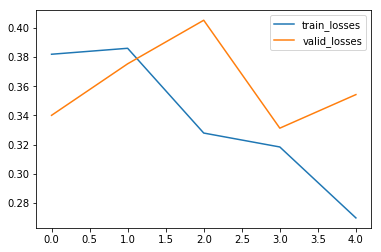

In [55]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

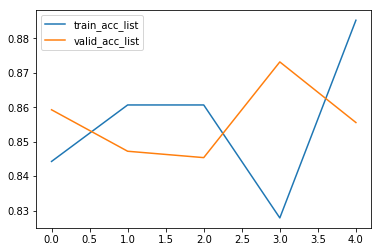

In [56]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()